### 0) importok, necessary stuffs

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

### 1) ADATBETÖLTÉS

In [87]:
data_file = "yeast.data"

column_names = [
    "sequence_name", "mcg", "gvh", "alm", "mit",
    "erl", "pox", "vac", "nuc", "class"
]

data = pd.read_csv(data_file, sep=r"\s+", header=None, names=column_names)

# Feature-ök és célváltozó
X = data.drop(columns=["class", "sequence_name"])  # azonosító oszlop elhagyása
y = data["class"]

### 2) AZ ADATOK SZERKEZETE (attribútumok, méret, célváltozó)

In [88]:
print("\n=== Data Size ===")
print(f"Number of Rows: {data.shape[0]}")
print(f"Number of Columns: {data.shape[1]}")

print("\n=== Attributes ===")
print(data.columns.tolist())

print("\n=== Attribute Types ===")
print(data.dtypes)

classes = data["class"].unique().tolist()
print("\n=== Target Variable: 'class' ===")
print("Unique Classes:", classes)
print(f"Number of Classes: {len(classes)}")


=== Data Size ===
Number of Rows: 1484
Number of Columns: 10

=== Attributes ===
['sequence_name', 'mcg', 'gvh', 'alm', 'mit', 'erl', 'pox', 'vac', 'nuc', 'class']

=== Attribute Types ===
sequence_name     object
mcg              float64
gvh              float64
alm              float64
mit              float64
erl              float64
pox              float64
vac              float64
nuc              float64
class             object
dtype: object

=== Target Variable: 'class' ===
Unique Classes: ['MIT', 'NUC', 'CYT', 'ME1', 'EXC', 'ME2', 'ME3', 'VAC', 'POX', 'ERL']
Number of Classes: 10


### 3) ALAPVETŐ STATISZTIKÁK ÉS VIZUALIZÁCIÓK (eloszlások, korreláció, osztályarányok)


=== Basic statistics (numeric attributes) ===
               mcg          gvh          alm          mit          erl  \
count  1484.000000  1484.000000  1484.000000  1484.000000  1484.000000   
mean      0.500121     0.499933     0.500034     0.261186     0.504717   
std       0.137299     0.123924     0.086670     0.137098     0.048351   
min       0.110000     0.130000     0.210000     0.000000     0.500000   
25%       0.410000     0.420000     0.460000     0.170000     0.500000   
50%       0.490000     0.490000     0.510000     0.220000     0.500000   
75%       0.580000     0.570000     0.550000     0.320000     0.500000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

               pox          vac          nuc  
count  1484.000000  1484.000000  1484.000000  
mean      0.007500     0.499885     0.276199  
std       0.075683     0.057797     0.106491  
min       0.000000     0.000000     0.000000  
25%       0.000000     0.480000     0.220000  
50% 

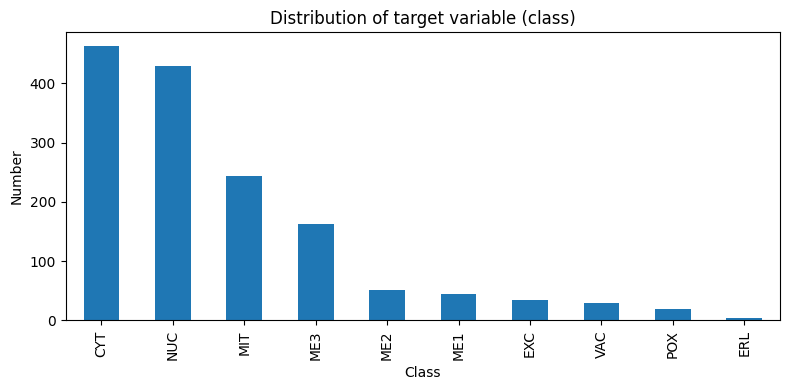

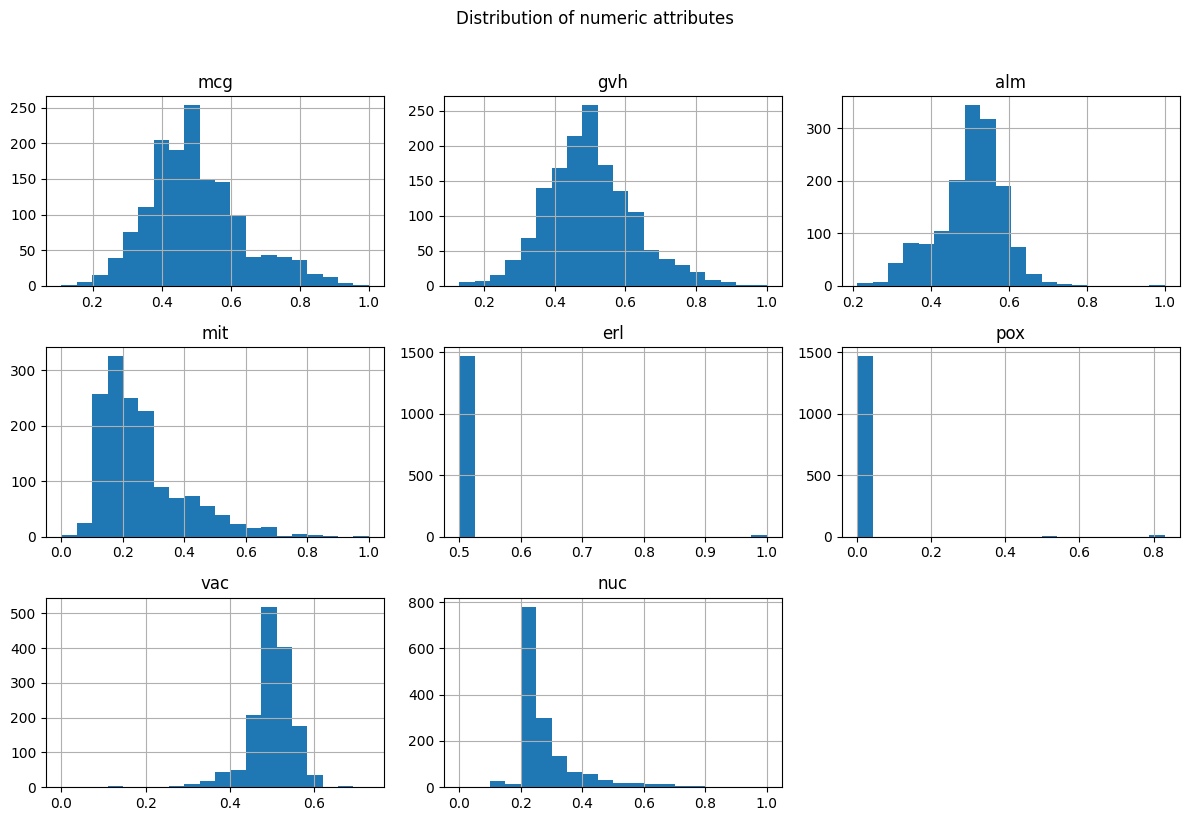

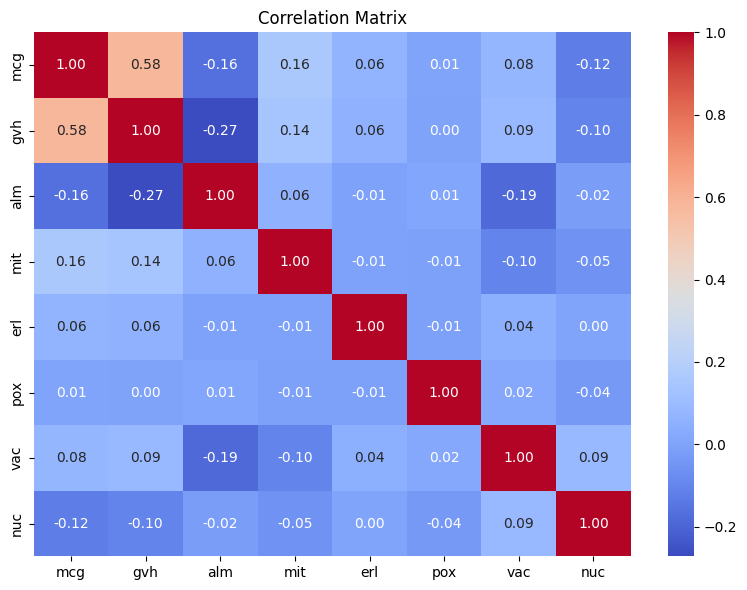

In [89]:
features = X.columns

print("\n=== Basic statistics (numeric attributes) ===")
print(data[features].describe())

print("\n=== Class proportions (number of items) ===")
print(y.value_counts())

print("\n=== Class proportions (%) ===")
print((y.value_counts(normalize=True) * 100).round(2))

# Osztályeloszlás plot
plt.figure(figsize=(8,4))
y.value_counts().plot(kind="bar")
plt.title("Distribution of target variable (class)")
plt.xlabel("Class")
plt.ylabel("Number")
plt.tight_layout()
plt.show()

# Histogramok
data[features].hist(bins=20, figsize=(12,8))
plt.suptitle("Distribution of numeric attributes", y=1.02)
plt.tight_layout()
plt.show()

# Korrelációs mátrix
corr = data[features].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

### 4) KÉT MODELL BETANÍTÁSA + ÖSSZEHASONLÍTÁS

In [90]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ritka osztályok miatt, n_splits=5 helyett =4
# UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
# warnings.warn(
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# -----------------------------
# Modell 1: Regularizált logisztikus regresszió
# -----------------------------
pipe_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=5000))
])

param_grid_lr = {
    "clf__C": [0.01, 0.1, 1, 10, 100],
    "clf__solver": ["lbfgs"]    
    
    # "clf__penalty": ["l2"],
    #FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
    # warnings.warn(
    # "clf__multi_class": ["auto"] 
    #
    # ValueError: Invalid parameter 'multi_class' for estimator LogisticRegression(C=0.01, max_iter=5000). Valid parameters are: ['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'].Cell Execution Error

}

grid_lr = GridSearchCV(pipe_lr, param_grid_lr, cv=cv, scoring="f1_macro", n_jobs=-1)
grid_lr.fit(X_train, y_train)

best_lr = grid_lr.best_estimator_
print("\n=== Logistic Regression (L2)===")
print("Best params:", grid_lr.best_params_)
print("Best CV macro-F1:", round(grid_lr.best_score_, 4))


# -----------------------------
# Modell 2: SVM (RBF)
# -----------------------------
pipe_svm = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel="rbf"))
])

param_grid_svm = {
    "clf__C": [0.1, 1, 10, 100],
    "clf__gamma": ["scale", 0.01, 0.1, 1]
}

grid_svm = GridSearchCV(pipe_svm, param_grid_svm, cv=cv, scoring="f1_macro", n_jobs=-1)
grid_svm.fit(X_train, y_train)

best_svm = grid_svm.best_estimator_
print("\n=== SVM (RBF)===")
print("Best params:", grid_svm.best_params_)
print("Best CV macro-F1:", round(grid_svm.best_score_, 4))


=== Logistic Regression (L2)===
Best params: {'clf__C': 1, 'clf__solver': 'lbfgs'}
Best CV macro-F1: 0.5423

=== SVM (RBF)===
Best params: {'clf__C': 10, 'clf__gamma': 0.01}
Best CV macro-F1: 0.5935


### 5) TESZT HALMAZ KIÉRTÉKELÉS (accuracy, macro-F1) + KONFÚZIÓS MÁTRIX


=== Logistic Regression - Test set ===
Accuracy: 0.6027
F1 (macro): 0.553
F1 (weighted): 0.591

Classification report:

              precision    recall  f1-score   support

         CYT       0.52      0.70      0.60        93
         ERL       1.00      1.00      1.00         1
         EXC       0.50      0.43      0.46         7
         ME1       0.80      0.89      0.84         9
         ME2       0.33      0.20      0.25        10
         ME3       0.79      0.84      0.82        32
         MIT       0.59      0.59      0.59        49
         NUC       0.66      0.50      0.57        86
         POX       1.00      0.25      0.40         4
         VAC       0.00      0.00      0.00         6

    accuracy                           0.60       297
   macro avg       0.62      0.54      0.55       297
weighted avg       0.60      0.60      0.59       297


=== SVM (RBF) - Test set ===
Accuracy: 0.596
F1 (macro): 0.5434
F1 (weighted): 0.5879

Classification report:

        

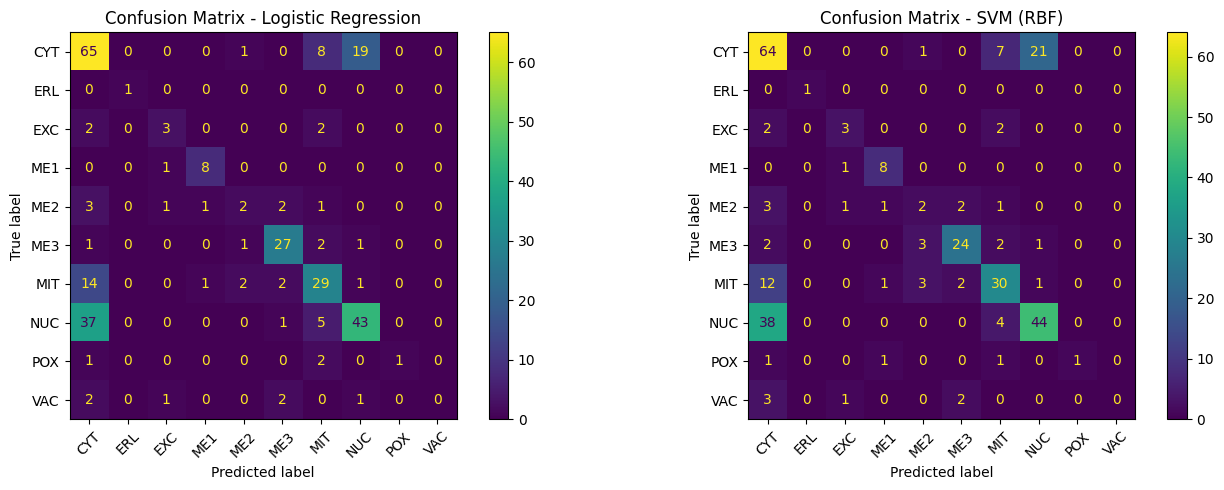

In [ ]:
#ugyanaz a logika > kiszervezni inkább függvénybe
def evaluate(model, X_test, y_test, name):
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average="macro")
    f1_weighted = f1_score(y_test, y_pred, average="weighted")

    print(f"\n=== {name} - Test set ===")
    print("Accuracy:", round(acc, 4))
    print("F1 (macro):", round(f1_macro, 4))
    print("F1 (weighted):", round(f1_weighted, 4))

    print("\nClassification report:\n")
    print(classification_report(y_test, y_pred, zero_division=0)) # warning némítása

    return y_pred


pred_lr = evaluate(best_lr, X_test, y_test, "Logistic Regression")
pred_svm = evaluate(best_svm, X_test, y_test, "SVM (RBF)")


# Konfúziós mátrixok
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ConfusionMatrixDisplay.from_predictions(
    y_test, pred_lr, ax=axes[0], xticks_rotation=45, values_format="d"
)
axes[0].set_title("Confusion Matrix - Logistic Regression")

ConfusionMatrixDisplay.from_predictions(
    y_test, pred_svm, ax=axes[1], xticks_rotation=45, values_format="d"
)
axes[1].set_title("Confusion Matrix - SVM (RBF)")

plt.tight_layout()
plt.show()

### 6) TANULÁSI GÖRBÉK (mindkét modellre)

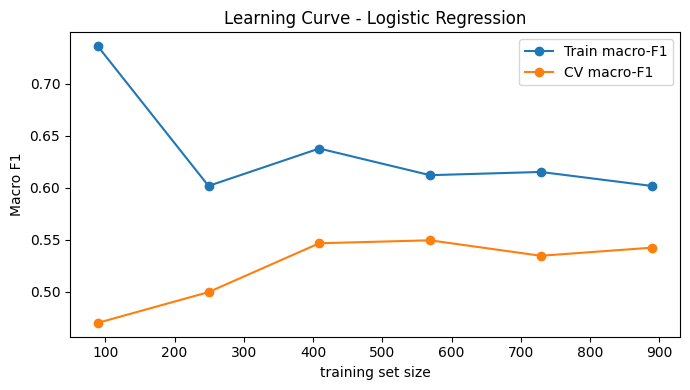

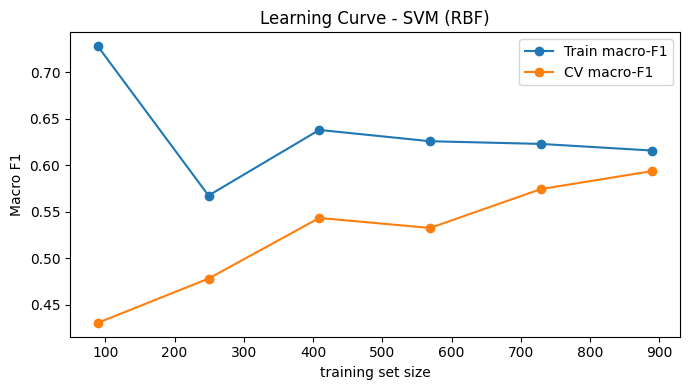

In [ ]:
#ugyanaz a logika > kiszervezni inkább függvénybe
def plot_learning_curve(estimator, X, y, title, cv):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=cv, scoring="f1_macro",
        train_sizes=np.linspace(0.1, 1.0, 6), n_jobs=-1
    )
    train_mean = train_scores.mean(axis=1)
    val_mean = val_scores.mean(axis=1)

    plt.figure(figsize=(7,4))
    plt.plot(train_sizes, train_mean, marker="o", label="Train macro-F1")
    plt.plot(train_sizes, val_mean, marker="o", label="CV macro-F1")
    plt.title(title)
    plt.xlabel("training set size")
    plt.ylabel("Macro F1")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_learning_curve(best_lr, X_train, y_train, "Learning Curve - Logistic Regression", cv)
plot_learning_curve(best_svm, X_train, y_train, "Learning Curve - SVM (RBF)", cv)